# Motivations

We want to model a high dimensional distribution $p(x)$. We can use Auto Regressive Models
like Pixel CNN, Pixel RNN. However, the sampling is slow because every dimension
is dependent of all previous dimensions, e.g. every pixel is dependent of all
previous pixels.

We can make some independence assumptions to make the sampling process faster.
The extreme case is that every dimension is independent of all other dimensions.
We want something in between. We assume that the dimensions are independent
given some hidden variable $z$:

$$p(x) = p_Z(z)p(x | z)$$

This type of models is called *Latent Variable Models*.

$p_Z(z)$ is the prior distribution over $z$ which is usually chosen to be a
distribution that is easy to sample from, e.g. uniform or Gaussian.
More complex $p_Z(z)$ allows more precise modeling of $p(x)$, e.g. $p_Z(z)$ is
 the output of a normalizing flow.
Prior learning is still an open research area.

# Problems

## Sampling
To sample from this model, we first draw $z$ from $p_Z(z)$ and then sample $x$ from $p(x | z)$.
$p(x | z)$ is usually a neural network with parameter $\theta$.

\begin{eqnarray}
z \sim p_Z(z) \\
x \sim p_\theta (x | z)
\end{eqnarray}

## Evaluating likelihood
Given a datapoint $x_0$ and a model $p_\theta (x)$, we can evaluate the likelihood of $x_0$.
Some applications of this: to detect out of distribution (OOD) datapoints.

\begin{eqnarray}
p_\theta (x_0) = \sum_{z \sim p_Z} p_Z(z) p_\theta(x|z)
\end{eqnarray}

## Training
LVMs are trained by maximum likelihood

\begin{eqnarray}
\underset{\theta}{\max} \sum_i \log p_\theta(x^{(i)}) = \sum_i \log \sum_z p_Z(z) p_\theta(x^{(i)} | z)
\end{eqnarray}

## Representation
We want $z$ to capture properties of $x$. A good representation is useful in many other problems, e.g. RL,
supervised learning, disentanglement, ...

$$x \rightarrow z$$

# Training LVMs
Given a training dataset $\mathcal{D} = \{ x^{(i)} \}_{i=1}^n$, we need to find parameter $\theta$ s.t.
the likelihood of the training data is maximized. The first step is to get an estimate of
the likelihood. We consider the prior sampling method:
## Prior sampling
Let's consider an example where the data is in 2D and $z$ is 1D.
The data consist of $10$ clusters as shown in the figure below.

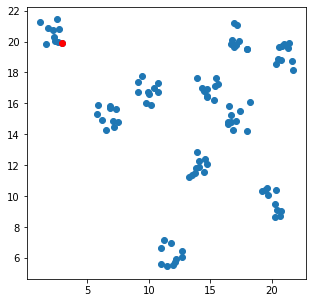

In [9]:
from matplotlib import pyplot as plt
import numpy as np

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
mu = np.random.random((10, 2)) * 20
data = []
for i in range(10):
    data.append(mu[i] + np.random.random((10, 2)) * 2)
data = np.concatenate(data, axis=0)
ax.scatter(data[:, 0], data[:, 1])
ax.scatter(data[0, 0], data[0, 1], c='r')

ax.contourf()

We use the mixture of Gaussians model:

\begin{eqnarray}
p_\theta(x) = \sum_{i = 1}^{10} p_Z(z) \mathcal{N}(x | \mu = f^{(i)}(z), \Sigma = g^{(i)}(z))
\end{eqnarray}

Assume that we have fitted the model to the data, i.e. each cluster is modeled by a
 Gaussian with mean $\mu^{i}$ and covariance $\Sigma^{(i)}$.

Given the red datapoint $x^{(0)} \sim \mathcal{N}(\mu^{(1)}, \Sigma^{(1)})$, we want to estimate $p_\theta(x^{(0)})$.
If we sample $z$ uniformly, 9 out of 10 times,
the selected a component which is not $\mathcal{N}(\mu^{(1)}, \Sigma^{(1)})$ and it will assign very low
probability to $x^{(0)}$. Because of that, in most cases (90%), the gradient signal is very small and unusable.
The situation is worse in higher dimensional space. The probability that a randomly sampled $z$ end up producing
the component near $x^{(0)}$ is practically $0$.

We want to sample $z$ such that the probability of $x^{0}$ under the model is
high.


## Importance sampling

We want to compute $\mathbb{E}_{p(x)} p(x) f(x)$. However, $p(x)$ is
- Hard to sample from, and/or
- Sample from $p(x)$ is not informative. For example, most of the density is
concentrated at the region where $f(x) \approx 0$. This is more visible for
high dimensional distributions.

We use a *proposal distribution* $q(x)$ that is
- Easy to sample from, and
- Samples from $q(x)$ is more informative, i.e. most of the density is
concentrated at the region where $f(x)$ is large.

\begin{eqnarray}
\mathbb{E}_{p(x)} p(x) f(x) & = & \sum_{x} p(x) f(x) \\
& = & \sum_{x} q(x) \frac{p(x)}{q(x)} f(x) \\
& = & \mathbb{E}_{q(x)} \frac{p(x)}{q(x)} f(x) \\
& \approx & \frac{1}{K} \sum_{i = 1}^K \frac{p(x^{(i)})}{q(x^{(i)})} f(x^{(i)}), \text{ where } x^{(i)} \sim q(x)
\end{eqnarray}

For LVM objective, $f(x) = \log p_\theta(x|z)$, and samples are taken from $p_Z(z)$.

\begin{eqnarray}
\sum_{i} \log \sum_z p_Z(z) p_\theta (x^{{i}} | z) \approx \sum_i \log \frac{1}{K} \sum_k^K \frac{p_Z(z^{(i)}_k)}{q_Z(z^{(i)}_{k})} p(x^{(i)}|z^{(i)}_{k}),
\end{eqnarray}
where $z^{(i)}_k \sim q(z)$.

Question: what is the good $q(z)$ given $x^{(i)}$?

Answer: $q^{(i)}(z) = p_\theta(z|x^{(i)})$. This is justified through the KL divergence
formulation.

\begin{eqnarray}
q^{(i)}(z) = p_\theta (z | x^{(i)}) = \frac{p_\theta (x^{(i)}|z) p_Z(z)}{p_\theta (x)}
\end{eqnarray}

We can optimize $q^{(i)}(z)$ by minimizing the KL divergence between
$q^{(i)}(z)$ and $p(z | x^{(i)})$.

\begin{eqnarray}
& & \underset{q(z)}{\min} KL(q(z) || p_\theta (z | x^{(i)}) \\
& = & \underset{q(z)}{\min} \mathbb{E}_{q(z)} \left[ \log \frac{q(z)}{p_\theta(z | x^{(i)})} \right] \\
& = & \underset{q(z)}{\min} \mathbb{E}_{q(z)} \left[ \log \frac{q(z) p_\theta(x^{(i)})}{p_\theta(x^{(i)} | z) p_Z(z)} \right] \\
& = & \underset{q(z)}{\min} \mathbb{E}_{q(z)} \left[ \log q(z) - \log p_\theta(x^{(i)} | z) - \log p_Z(z) \right] + C
\end{eqnarray}

We can optimize the parameter of $q(z)$ to find the optimal variational distribution.
One method for doing this is called Stochastic Variational Inference.
However, running SVI for each datapoint $x^{(i)}$ is expensive.

Instead of solving $n$ optimization problems, we learn a model that solves
the variational inference problem given the datapoint $x$, i.e. a function
from $x$ to $z$. This is called Amortized Variational Inference. VAEs follow
this approach. The function is implemented by a neural network.

## Amortized Variational Inference
We parametrize $q$ with $\phi$, the problem becomes

\begin{eqnarray}
&  & \underset{\phi}{\min} \sum_i KL(q_\phi(z) || p_\theta (z | x^{(i)}) \\
& = & \underset{\phi}{\min} \sum_i \mathbb{E} \left[ \log \frac{q_\phi(z)}{p_\theta(z | x^{(i)}} \right]
\end{eqnarray}

The problem becomes finding $q_\phi$ that minimizes an expectation. Approaches to
this problem are:
- Likelihood Ratio Gradient: tends to have high variance for high dimensional distributions (see examples)
- Path Wise Derivative (Reparameterization Trick): is easily applicable to only a limited number of
distributions, e.g. Gaussian, Poisson, ... Can be applied to more complicated
distributions via the use of flow models.

## Importance Weighted AutoEncoder (IWAE)

The objectives for IWAE are

- The maximum likelihood objective

$$\frac{1}{K} \sum_i \frac{p_Z(z^{(i)}_k)}{q_\phi (z^{(i)}_k)} p_\theta(x^{(i)} | z^{(i)}_k) \text{ where } z^{(i)}_k \sim q_\phi(z; x^{(i)})$$

- The KL divergence

$$\underset{\phi}{\min} \sum_i KL\left(q_\phi\left(z; x^{(i)}\right) || p_\theta\left(z | x^{(i)}\right)\right)$$

We can jointly optimize the 2 objectives by maximizing the difference between the
likelihood and the KL.